Side note: we are evaluating particle level information
maybe we should also do the event level information

In [1]:
import itertools
import logging
from pathlib import Path
import numba as nb

import awkward as ak
import click
import h5py as h5
import numpy as np
import vector

from coffea.hist.plot import clopper_pearson_interval
import matplotlib.pyplot as plt

# from src.data.cms.convert_to_h5 import MIN_JETS, N_JETS, N_FJETS

vector.register_awkward()

logging.basicConfig(level=logging.INFO)

/Users/billyli/miniforge_x86_new/envs/phys239/lib/python3.7/site-packages/coffea/util.py:154: FutureWarning: In coffea version v2023.3.0 (target date: 31 Mar 2023), this will be an error.
(Set coffea.deprecations_as_errors = True to get a stack trace now.)
ImportError: coffea.hist is deprecated
  warnings.warn(message, FutureWarning)


In [2]:
# read test target file
test_file = "//Users/billyli/UCSD/hhh/reports/bv2/hhh_test.h5"
test_h5 = h5.File(test_file)

# read spanet prediction
spanet_file = "//Users/billyli/UCSD/hhh/reports/bv2/dp_on/pred_v53.h5"
s_h5 = h5.File(spanet_file)

# read baseline prediction
baseline_file = "//Users/billyli/UCSD/hhh/reports/bv2/pred_baseline.h5"
b_h5 = h5.File(baseline_file)

# read spanet prediction
pb_off_file = "//Users/billyli/UCSD/hhh/reports/bv2/pb_off_pred_v61.h5"
pb_h5 = h5.File(pb_off_file, 'a')

eval_file = "//Users/billyli/UCSD/hhh/reports/bv2/best/020624_1gpu.h5"
eval_h5 = h5.File(eval_file, 'a')

In [3]:
tag = '022624'

In [4]:
print(pb_h5.keys())

<KeysViewHDF5 ['INPUTS', 'TARGETS']>


In [5]:
if 'TARGETS' not in pb_h5.keys():
    pb_h5["INPUTS"] = pb_h5["SpecialKey.Inputs"]
    pb_h5["TARGETS"] = pb_h5["SpecialKey.Targets"]

In [6]:
print(pb_h5.keys())

<KeysViewHDF5 ['INPUTS', 'TARGETS']>


### Reco Boosted

In [7]:
def reset_collision_dp(dps, aps):
    ap_filter = aps < 1/(13*13)
    dps_reset = dps
    dps_reset[ap_filter] = 0
    return dps

In [8]:
def dp_to_HiggsNumProb(dps):
    # get maximum number of targets
    Nmax = dps.shape[-1]
    
    # prepare a list for constructing [P_0H, P_1H, P_2H, ...]
    probs = []
    
    # loop through all possible number of existing targets
    for N in range(Nmax+1):
        # get all combinations of targets
        combs = list(itertools.combinations(range(Nmax),N))
    
        # calculate the probability of N particles existing for each combination
        P_exist_per_comb = [np.prod(dps[:,list(comb)], axis=-1) for comb in combs]
        
        # calculate the probability fo Nmax-N particles not existing for each  combination
        P_noexist_per_comb = [np.prod(1- dps[:, list(set(range(Nmax))-set(comb))], axis=-1) for comb in combs]
        
        # concatenate each combination to array for further calculation   
        P_exist_per_comb = [np.reshape(P_comb_e, newshape=(-1,1)) for P_comb_e in P_exist_per_comb]
        P_exist_per_comb = np.concatenate(P_exist_per_comb, axis=1)
        P_noexist_per_comb = [np.reshape(P_comb_e, newshape=(-1,1)) for P_comb_e in P_noexist_per_comb]
        P_noexist_per_comb = np.concatenate(P_noexist_per_comb, axis=1)
        
        # for each combination, calculate the joint probability 
        # of N particles existing and Nmax-N not existing
        P_per_comb = P_exist_per_comb * P_noexist_per_comb
        
        # sum over all possible configurations of N existing and Nmax-N not existing
        P = np.sum(P_per_comb, axis=-1)
        
        # reshape and add to the prob list
        probs.append(np.reshape(P, newshape=(-1,1)))

    # convert the probs list to arr
    probs_arr = np.concatenate(probs, axis=1)
    
    return probs_arr

In [9]:
def sel_pred_bH_by_dp_ap(dps, aps, bb_ps):
    # get most possible number of H_reco by dps
    HiggsNumProb = dp_to_HiggsNumProb(dps)
    HiggsNum = np.argmax(HiggsNumProb, axis=-1)
    
    # get the top N (dp x ap) jet assignment indices
    ps = dps*aps
    idx_descend = np.flip(np.argsort(ps, axis=-1), axis=-1)
    idx_sel = [idx_e[:N_e] for idx_e, N_e in zip(idx_descend, HiggsNum)]
    
    # select the predicted bb assignment via the indices
    bb_ps_sel = bb_ps[idx_sel]
    
    # require bb assignment is a fatjet
    ak8Filter = bb_ps_sel>9
    bb_ps_passed = bb_ps_sel.mask[ak8Filter]
    bb_ps_passed = ak.drop_none(bb_ps_passed)
    
    return bb_ps_passed

In [10]:
def sel_target_bH_by_mask(bb_ts, bh_pts, bh_masks):
    bb_ts_selected = bb_ts.mask[bh_masks]
    bb_ts_selected = ak.drop_none(bb_ts_selected)
    
    bh_selected_pts = bh_pts.mask[bh_masks]
    bh_selected_pts = ak.drop_none(bh_selected_pts)
    
    return bb_ts_selected, bh_selected_pts

In [11]:
# A pred look up table is in shape
# [event,
#    pred_H, 
#       [correct, pred_H_pt]]
def gen_pred_bH_LUT(bb_ps_passed, bb_ts_selected, fj_pts):
    LUT = []
    # for each event
    for bb_t_event, bb_p_event, fj_pt_event in zip(bb_ts_selected, bb_ps_passed, fj_pts):
        # for each predicted bb assignment, check if any target H have a same bb assignment
        LUT_event = []
        for i, bb_p in enumerate(bb_p_event):
            correct = 0
            predH_pt = fj_pt_event[bb_p-10]
            for bb_t in bb_t_event:
                if bb_p == bb_t+10:
                    correct = 1
            LUT_event.append([correct, predH_pt])
        LUT.append(LUT_event)
    return LUT

In [12]:
# A target look up table is in shape
# [event,
#    target_H, 
#        target_bb_assign,
#           [retrieved, targetH_pt]]
def gen_target_bH_LUT(bb_ps_passed, bb_ts_selected, targetH_pts):
    LUT = []
    # for each event
    for bb_t_event, bb_p_event, targetH_pts_event in zip(bb_ts_selected, bb_ps_passed, targetH_pts):
        # for each target fatjet, check if the predictions have a p fatject same with the t fatjet
        LUT_event = []
        for i, bb_t in enumerate(bb_t_event):
            retrieved = 0
            targetH_pt = targetH_pts_event[i]
            for bb_p in bb_p_event:
                if bb_p == bb_t+10:
                    retrieved = 1
            LUT_event.append([retrieved, targetH_pt])
        LUT.append(LUT_event)
    return LUT

In [13]:
# generate pred/target LUT
# each entry corresponds to [recoH correct or not, reco H pt]
# or 
# [targetH retrieved or not, target H pt]
def parse_boosted_w_target(testfile, predfile):
    # Collect H pt, mask, target and predicted jet and fjets for 3 Hs in each event
    # h pt
    bh1_pt = np.array(testfile['TARGETS']['bh1']['pt'])
    bh2_pt = np.array(testfile['TARGETS']['bh2']['pt'])
    bh3_pt = np.array(testfile['TARGETS']['bh3']['pt'])

    # mask
    bh1_mask = np.array(testfile['TARGETS']['bh1']['mask'])
    bh2_mask = np.array(testfile['TARGETS']['bh2']['mask'])
    bh3_mask = np.array(testfile['TARGETS']['bh3']['mask'])

    # target assignment
    bb_bh1_t = np.array(testfile["TARGETS"]["bh1"]['bb'])
    bb_bh2_t = np.array(testfile["TARGETS"]["bh2"]['bb'])
    bb_bh3_t = np.array(testfile["TARGETS"]["bh3"]['bb'])

    try:
        # pred assignment
        bb_bh1_p = np.array(predfile["TARGETS"]["bh1"]['bb'])
        bb_bh2_p = np.array(predfile["TARGETS"]["bh2"]['bb'])
        bb_bh3_p = np.array(predfile["TARGETS"]["bh3"]['bb'])
    
        # boosted Higgs detection probability
        dp_bh1 = np.array(predfile["TARGETS"]["bh1"]['detection_probability'])
        dp_bh2 = np.array(predfile["TARGETS"]["bh2"]['detection_probability'])
        dp_bh3 = np.array(predfile["TARGETS"]["bh3"]['detection_probability'])

        # fatjet assignment probability
        ap_bh1 = np.array(predfile["TARGETS"]["bh1"]['assignment_probability'])
        ap_bh2 = np.array(predfile["TARGETS"]["bh2"]['assignment_probability'])
        ap_bh3 = np.array(predfile["TARGETS"]["bh3"]['assignment_probability'])
    except:
        # pred assignment
        bb_bh1_p = np.array(predfile["TARGETS"]["bh1"]['bb'])+10
        bb_bh2_p = np.array(predfile["TARGETS"]["bh2"]['bb'])+10
        bb_bh3_p = np.array(predfile["TARGETS"]["bh3"]['bb'])+10
    
         # boosted Higgs detection probability
        dp_bh1 = np.array(predfile["TARGETS"]["bh1"]['mask']).astype('float')
        dp_bh2 = np.array(predfile["TARGETS"]["bh2"]['mask']).astype('float')
        dp_bh3 = np.array(predfile["TARGETS"]["bh3"]['mask']).astype('float')

        # fatjet assignment probability
        ap_bh1 = np.array(predfile["TARGETS"]["bh1"]['mask']).astype('float')
        ap_bh2 = np.array(predfile["TARGETS"]["bh2"]['mask']).astype('float')
        ap_bh3 = np.array(predfile["TARGETS"]["bh3"]['mask']).astype('float')
    
    # collect fatjet pt
    fj_pt = np.array(testfile['INPUTS']['BoostedJets']['fj_pt'])
    
    dps = np.concatenate((dp_bh1.reshape(-1, 1), dp_bh2.reshape(-1, 1), dp_bh3.reshape(-1, 1)), axis=1)
    aps = np.concatenate((ap_bh1.reshape(-1, 1), ap_bh2.reshape(-1, 1), ap_bh3.reshape(-1, 1)), axis=1)

    # convert some arrays to ak array
    bb_ps = np.concatenate((bb_bh1_p.reshape(-1, 1), bb_bh2_p.reshape(-1, 1), bb_bh3_p.reshape(-1, 1)), axis=1)
    bb_ps = ak.Array(bb_ps)
    bb_ts = np.concatenate((bb_bh1_t.reshape(-1, 1), bb_bh2_t.reshape(-1, 1), bb_bh3_t.reshape(-1, 1)), axis=1)
    bb_ts = ak.Array(bb_ts)
    fj_pt = ak.Array(fj_pt)
    bh_masks = np.concatenate((bh1_mask.reshape(-1, 1), bh2_mask.reshape(-1, 1), bh3_mask.reshape(-1, 1)), axis=1)
    bh_masks = ak.Array(bh_masks)
    bh_pts = np.concatenate((bh1_pt.reshape(-1, 1), bh2_pt.reshape(-1, 1), bh3_pt.reshape(-1, 1)), axis=1)
    bh_pts = ak.Array(bh_pts)
    
    # select predictions and targets
    bb_ps_selected = sel_pred_bH_by_dp_ap(dps, aps, bb_ps)
    bb_ts_selected, targetH_selected_pts = sel_target_bH_by_mask(bb_ts, bh_pts, bh_masks)
    
    # generate correct/retrieved LUT for pred/target respectively
    LUT_pred = gen_pred_bH_LUT(bb_ps_selected, bb_ts_selected, fj_pt)
    LUT_target = gen_target_bH_LUT(bb_ps_selected, bb_ts_selected, targetH_selected_pts)
    
    # reconstruct bH to remove overlapped ak4 jets
    fj_eta = np.array(testfile['INPUTS']['BoostedJets']['fj_eta'])
    fj_phi = np.array(testfile['INPUTS']['BoostedJets']['fj_phi'])
    fj_mass = np.array(testfile['INPUTS']['BoostedJets']['fj_mass'])
    
    fjs = ak.zip(
        {
            "pt": fj_pt,
            "eta": fj_eta,
            "phi": fj_phi,
            "mass": fj_mass,
        },
        with_name="Momentum4D"
    )
    fj_reco = fjs[bb_ps_selected-10]
    
    return LUT_pred, LUT_target, fj_reco

In [14]:
def get_unoverlapped_jet_index(fjs, js, dR_min=0.8):
    overlapped = ak.sum(js[:, np.newaxis].deltaR(fjs)<dR_min, axis=-2)>0
    jet_index_passed = ak.local_index(js).mask[~overlapped]
    jet_index_passed = ak.drop_none(jet_index_passed)
    return jet_index_passed

In [15]:
def sel_pred_h_by_dp_ap(dps, aps, b1_ps, b2_ps):
    # get most possible number of H_reco by dps
    HiggsNumProb = dp_to_HiggsNumProb(dps)
    HiggsNum = np.argmax(HiggsNumProb, axis=-1)
    
    # get the top N (dp x ap) jet assignment indices
    ps = dps*aps
    idx_descend = np.flip(np.argsort(ps, axis=-1), axis=-1)
    
    idx_sel = [idx_e[:N_e] for idx_e, N_e in zip(idx_descend, HiggsNum)]
    
    # select the predicted b assignment via the indices
    b1_ps_sel = b1_ps[idx_sel]
    b2_ps_sel = b2_ps[idx_sel]

    # require b1 b2 assignment are AK4 jet
    b1_ak4_filter = b1_ps_sel<10
    b2_ak4_filter = b2_ps_sel<10
    filter = b1_ak4_filter & b2_ak4_filter
    
    b1_ps_passed = b1_ps_sel.mask[filter]
    b1_ps_passed = ak.drop_none(b1_ps_passed)
    
    b2_ps_passed = b2_ps_sel.mask[filter]
    b2_ps_passed = ak.drop_none(b2_ps_passed)
    
    return b1_ps_passed, b2_ps_passed

In [16]:
def sel_target_h_by_mask(b1_ts, b2_ts, h_pts, bi_cat_H, h_masks):
    b1_ts_selected = b1_ts.mask[h_masks]
    b1_ts_selected = ak.drop_none(b1_ts_selected)
    
    b2_ts_selected = b2_ts.mask[h_masks]
    b2_ts_selected = ak.drop_none(b2_ts_selected)
    
    h_selected_pts = h_pts.mask[h_masks]
    h_selected_pts = ak.drop_none(h_selected_pts)
    
    bi_cat_H_passed = bi_cat_H.mask[h_masks]
    bi_cat_H_passed = ak.drop_none(bi_cat_H_passed)
    
    return b1_ts_selected, b2_ts_selected, h_selected_pts, bi_cat_H_passed

In [17]:
# A pred look up table is in shape
# [event,
#    pred_H, 
#       [correct_or_not, pt, overlap_w_H_reco, has_boost_H_target, which_H_target]]
@nb.njit
def gen_pred_h_LUT(b1_ps_passed, b2_ps_passed, b1_ts_selected, b2_ts_selected, js, goodJetIdx, bi_cat_H_selected, builder):
    # for each event
    for b1_ps_e, b2_ps_e, b1_ts_e, b2_ts_e, jets_e, goodJetIdx_e, bi_cat_H_e in zip(b1_ps_passed, b2_ps_passed, b1_ts_selected, b2_ts_selected, js, goodJetIdx, bi_cat_H_selected):
        # for each predicted bb assignment, check if any target H have a same bb assignment
        builder.begin_list()
        for b1_p, b2_p in zip(b1_ps_e, b2_ps_e):
            if (b1_p in goodJetIdx_e) and (b2_p in goodJetIdx_e):
                overlap = 0
            else:
                overlap = 1
            correct = 0
            has_t_bH = -1
            bH = -1
            
            predH_pt = (jets_e[b1_p]+jets_e[b2_p]).pt
#             try:
#                 predH_pt = (jets_e[b1_p]+jets_e[b2_p]).pt
#             except:
# #                 print(jets_e[b1_p])
# #                 print(jets_e[b2_p])
#                   pass
            
            for i, (b1_t, b2_t, bi_cat_H) in enumerate(zip(b1_ts_e, b2_ts_e, bi_cat_H_e)):
                if set((b1_p, b2_p)) == set((b1_t, b2_t)):
                    correct = 1
                    has_t_bH = bi_cat_H
                    bH = i
                    
            builder.begin_list()
            builder.append(correct)
            builder.append(predH_pt)
            builder.append(overlap)
            builder.append(has_t_bH)
            builder.append(bH)
            builder.append(b1_p)
            builder.append(b2_p)
            builder.end_list()
        
        builder.end_list()
    return builder

In [18]:
# A target look up table is in shape
# [event,
#    target_H, 
#        target_bb_assign,
#           [retrieved, targetH_pt, can_boost_reco]]
@nb.njit
def gen_target_h_LUT(b1_ps_passed, b2_ps_passed, b1_ts_selected, b2_ts_selected, targetH_pts, bi_cat_H_selected, builder):
    # for each event
    for b1_ps_e, b2_ps_e, b1_ts_e, b2_ts_e, tH_pts_e, bi_cat_H_e in zip(b1_ps_passed, b2_ps_passed, b1_ts_selected, b2_ts_selected, targetH_pts, bi_cat_H_selected):
        # for each target fatjet, check if the predictions have a p fatject same with the t fatjet
        builder.begin_list()
        for b1_t, b2_t, tH_pt, bi_cat_H in zip(b1_ts_e, b2_ts_e, tH_pts_e, bi_cat_H_e):
            retrieved = 0
            can_boost_reco = bi_cat_H
            for b1_p, b2_p in zip(b1_ps_e, b2_ps_e):
                if set((b1_p, b2_p)) == set((b1_t, b2_t)):
                    retrieved = 1
            builder.begin_list()
            builder.append(retrieved)
            builder.append(tH_pt)
            builder.append(can_boost_reco)
            builder.end_list()
        
        builder.end_list()
    return builder

In [19]:
def parse_resolved_w_target(testfile, predfile, fjs_reco=None):
    # h pt
    h1_pt = np.array(testfile['TARGETS']['h1']['pt'])
    h2_pt = np.array(testfile['TARGETS']['h2']['pt'])
    h3_pt = np.array(testfile['TARGETS']['h3']['pt'])
    
    # resolved mask
    h1_mask = np.array(testfile['TARGETS']['h1']['mask'])
    h2_mask = np.array(testfile['TARGETS']['h2']['mask'])
    h3_mask = np.array(testfile['TARGETS']['h3']['mask'])
    
    h_masks = np.concatenate((h1_mask.reshape(-1, 1), h2_mask.reshape(-1, 1), h3_mask.reshape(-1, 1)), axis=1)
    # h_masks = h_masks.astype(float)
    # h_masks = ak.Array(h_masks)
    
    # boosted mask
    bh1_mask = np.array(testfile['TARGETS']['bh1']['mask'])
    bh2_mask = np.array(testfile['TARGETS']['bh2']['mask'])
    bh3_mask = np.array(testfile['TARGETS']['bh3']['mask'])
    
    bh_masks = np.concatenate((bh1_mask.reshape(-1, 1), bh2_mask.reshape(-1, 1), bh3_mask.reshape(-1, 1)), axis=1)
    # bh_masks = bh_masks.astype(float)
    # bh_masks = ak.Array(bh_masks)
    
    # findout which resolved higgs also have boosted reco
    bi_cat_H = h_masks & bh_masks
    bi_cat_H = bi_cat_H.astype(float)
    bi_cat_H = ak.Array(bi_cat_H)
    
    
    # target assignments
    b1_h1_t = np.array(testfile["TARGETS"]["h1"]['b1']).astype('int')
    b1_h2_t = np.array(testfile["TARGETS"]["h2"]['b1']).astype('int')
    b1_h3_t = np.array(testfile["TARGETS"]["h3"]['b1']).astype('int')

    b2_h1_t = np.array(testfile["TARGETS"]["h1"]['b2']).astype('int')
    b2_h2_t = np.array(testfile["TARGETS"]["h2"]['b2']).astype('int')
    b2_h3_t = np.array(testfile["TARGETS"]["h3"]['b2']).astype('int')
    
    # predict assignments
    b1_h1_p = np.array(predfile["TARGETS"]["h1"]['b1']).astype('int')
    b1_h2_p = np.array(predfile["TARGETS"]["h2"]['b1']).astype('int')
    b1_h3_p = np.array(predfile["TARGETS"]["h3"]['b1']).astype('int')

    b2_h1_p = np.array(predfile["TARGETS"]["h1"]['b2']).astype('int')
    b2_h2_p = np.array(predfile["TARGETS"]["h2"]['b2']).astype('int')
    b2_h3_p = np.array(predfile["TARGETS"]["h3"]['b2']).astype('int')

    # resolved Higgs detection probability
    dp_h1 = np.array(predfile["TARGETS"]["h1"]['detection_probability'])
    dp_h2 = np.array(predfile["TARGETS"]["h2"]['detection_probability'])
    dp_h3 = np.array(predfile["TARGETS"]["h3"]['detection_probability'])

    # ak4 jets assignment probability
    ap_h1 = np.array(predfile["TARGETS"]["h1"]['assignment_probability'])
    ap_h2 = np.array(predfile["TARGETS"]["h2"]['assignment_probability'])
    ap_h3 = np.array(predfile["TARGETS"]["h3"]['assignment_probability'])

    # reconstruct jet 4-momentum objects
    j_pt = np.array(testfile['INPUTS']['Jets']['pt'])
    j_eta = np.array(testfile['INPUTS']['Jets']['eta'])
    j_phi = np.array(testfile['INPUTS']['Jets']['phi'])
    j_mass = np.array(testfile['INPUTS']['Jets']['mass'])
    js = ak.zip(
        {
            "pt": j_pt,
            "eta": j_eta,
            "phi": j_phi,
            "mass": j_mass,
        },
        with_name="Momentum4D"
    )
    
    # convert some numpy arrays to ak arrays
    dps = np.concatenate((dp_h1.reshape(-1, 1), dp_h2.reshape(-1, 1), dp_h3.reshape(-1, 1)), axis=1)
    # dps = ak.Array(dps)
    aps = np.concatenate((ap_h1.reshape(-1, 1), ap_h2.reshape(-1, 1), ap_h3.reshape(-1, 1)), axis=1)
    # aps = ak.Array(aps)
    
    dps = reset_collision_dp(dps, aps)
    
    b1_ps = np.concatenate((b1_h1_p.reshape(-1, 1), b1_h2_p.reshape(-1, 1), b1_h3_p.reshape(-1, 1)), axis=1)
    b1_ps = ak.Array(b1_ps)
    b1_ts = np.concatenate((b1_h1_t.reshape(-1, 1), b1_h2_t.reshape(-1, 1), b1_h3_t.reshape(-1, 1)), axis=1)
    b1_ts = ak.Array(b1_ts)
    b2_ps = np.concatenate((b2_h1_p.reshape(-1, 1), b2_h2_p.reshape(-1, 1), b2_h3_p.reshape(-1, 1)), axis=1)
    b2_ps = ak.Array(b2_ps)
    b2_ts = np.concatenate((b2_h1_t.reshape(-1, 1), b2_h2_t.reshape(-1, 1), b2_h3_t.reshape(-1, 1)), axis=1)
    b2_ts = ak.Array(b2_ts)

    
    
    h_pts = np.concatenate((h1_pt.reshape(-1, 1), h2_pt.reshape(-1, 1), h3_pt.reshape(-1, 1)), axis=1)
    h_pts = ak.Array(h_pts)
    
    # select predictions and targets
    b1_ts_selected, b2_ts_selected, targetH_selected_pts, bi_cat_H_selected = sel_target_h_by_mask(b1_ts, b2_ts, h_pts, bi_cat_H, h_masks)
    b1_ps_selected, b2_ps_selected = sel_pred_h_by_dp_ap(dps, aps, b1_ps, b2_ps)
    
    # find jets that are overlapped with reco boosted Higgs
    if fjs_reco is None:
        goodJetIdx =  ak.local_index(js)
    else:
        goodJetIdx = get_unoverlapped_jet_index(fjs_reco, js, dR_min=0.4)
    
    # generate look up tables
    LUT_pred = gen_pred_h_LUT(b1_ps_selected, b2_ps_selected, b1_ts_selected, b2_ts_selected, js, goodJetIdx, bi_cat_H_selected, ak.ArrayBuilder()).snapshot()
    LUT_target = gen_target_h_LUT(b1_ps_selected, b2_ps_selected, b1_ts_selected, b2_ts_selected, targetH_selected_pts, bi_cat_H_selected, ak.ArrayBuilder()).snapshot()
    
    
    return LUT_pred, LUT_target, goodJetIdx

In [20]:
# calculate efficiency
# if bins=None, put all data in a single bin
def calc_eff(LUT_boosted_pred, LUT_resolved_pred, bins):

    predHs = []
    
    if LUT_boosted_pred is not None:
        # boosted H don't need post processing
        predHs_boosted = [predH for event in LUT_boosted_pred for predH in event]
        predHs += predHs_boosted

    if LUT_resolved_pred is not None:
        # Remove overlapped resolved H_reco 
        predHs_resolved = [predH[0:2] for event in LUT_resolved_pred for predH in event if predH[2]==0]
        predHs += predHs_resolved
        
    # then merge into the list with their pT
    predHs = np.array(predHs)
    
    predHs_inds = np.digitize(predHs[:,1], bins)
    
    correctTruth_per_bin = []
    for bin_i in range(1, len(bins)):
        correctTruth_per_bin.append(predHs[:,0][predHs_inds==bin_i])
    correctTruth_per_bin = ak.Array(correctTruth_per_bin)
    
    means = ak.mean(correctTruth_per_bin, axis=-1)
    
    errs = np.abs(
    clopper_pearson_interval(num=ak.sum(correctTruth_per_bin, axis=-1),\
                             denom=ak.num(correctTruth_per_bin, axis=-1)) - means
    )
    
    return means, errs

In [21]:
# calculate purity
def calc_pur(LUT_boosted_target, LUT_resolved_target, bins):

    targetHs = []

    if LUT_boosted_target is not None:
        # boosted H don't need post processing
        targetHs_boosted = [targetH for event in LUT_boosted_target for targetH in event]
        targetHs += targetHs_boosted

    if LUT_resolved_target is not None:
        # only consider resolved target H that doesn't have a corresponding boosted H target
        targetHs_resolved = [targetH[0:2] for event in LUT_resolved_target for targetH in event if targetH[2]==0]
        targetHs += targetHs_resolved

    targetHs = np.array(targetHs)

    targetHs_inds = np.digitize(targetHs[:,1], bins)
    
    correctTruth_per_bin = []
    for bin_i in range(1, len(bins)):
        correctTruth_per_bin.append(targetHs[:,0][targetHs_inds==bin_i])
    correctTruth_per_bin = ak.Array(correctTruth_per_bin)
    
    means = ak.mean(correctTruth_per_bin, axis=-1)
    
    errs = np.abs(
    clopper_pearson_interval(num=ak.sum(correctTruth_per_bin, axis=-1),\
                             denom=ak.num(correctTruth_per_bin, axis=-1)) - means
    )
    
    return means, errs

In [22]:
bins = np.arange(0, 1000, 50)
bin_centers = [(bins[i]+bins[i+1])/2 for i in range(bins.size-1)]
xerr=(bins[1]-bins[0])/2*np.ones(bins.shape[0]-1)

In [23]:
LUT_boosted_pred_spanet, LUT_boosted_target_spanet, fjs_reco_spanet = parse_boosted_w_target(test_h5, s_h5)
LUT_resolved_pred_spanet, LUT_resolved_target_spanet, _ = parse_resolved_w_target(test_h5, s_h5, fjs_reco=None)
LUT_resolved_wOR_pred_spanet, LUT_resolved_wOR_target_spanet, _ = parse_resolved_w_target(test_h5, s_h5, fjs_reco=fjs_reco_spanet)

In [24]:
LUT_boosted_pred_base, LUT_boosted_target_base, fjs_reco_base = parse_boosted_w_target(test_h5, b_h5)
LUT_resolved_pred_base, LUT_resolved_target_base, _ = parse_resolved_w_target(test_h5, b_h5, fjs_reco=None)
LUT_resolved_wOR_pred_base, LUT_resolved_wOR_target_base, _ = parse_resolved_w_target(test_h5, b_h5, fjs_reco=fjs_reco_base)

In [25]:
LUT_boosted_pred_pb, LUT_boosted_target_pb, fjs_reco_pb = parse_boosted_w_target(test_h5, pb_h5)
LUT_resolved_pred_pb, LUT_resolved_target_pb, _ = parse_resolved_w_target(test_h5, pb_h5, fjs_reco=None)
LUT_resolved_wOR_pred_pb, LUT_resolved_wOR_target_pb, _ = parse_resolved_w_target(test_h5, pb_h5, fjs_reco=fjs_reco_pb)

In [26]:
LUT_boosted_pred_eval, LUT_boosted_target_eval, fjs_reco_eval = parse_boosted_w_target(test_h5, eval_h5)
LUT_resolved_pred_eval, LUT_resolved_target_eval, _ = parse_resolved_w_target(test_h5, eval_h5, fjs_reco=None)
LUT_resolved_wOR_pred_eval, LUT_resolved_wOR_target_eval, _ = parse_resolved_w_target(test_h5, eval_h5, fjs_reco=fjs_reco_eval)

In [27]:
eff_s, efferr_s = calc_eff(LUT_boosted_pred_spanet, LUT_resolved_wOR_pred_spanet, bins)
pur_s, purerr_s = calc_pur(LUT_boosted_target_spanet, LUT_resolved_wOR_target_spanet, bins)

In [28]:
eff_b, efferr_b = calc_eff(LUT_boosted_pred_base, LUT_resolved_wOR_pred_base, bins)
pur_b, purerr_b = calc_pur(LUT_boosted_target_base, LUT_resolved_wOR_target_base, bins)

In [29]:
eff_pb, efferr_pb = calc_eff(LUT_boosted_pred_pb, LUT_resolved_wOR_pred_pb, bins)
pur_pb, purerr_pb = calc_pur(LUT_boosted_target_pb, LUT_resolved_wOR_target_pb, bins)

In [30]:
eff_eval, efferr_eval = calc_eff(LUT_boosted_pred_eval, LUT_resolved_wOR_pred_eval, bins)
pur_eval, purerr_eval = calc_pur(LUT_boosted_target_eval, LUT_resolved_wOR_target_eval, bins)

(-0.1, 1.1)

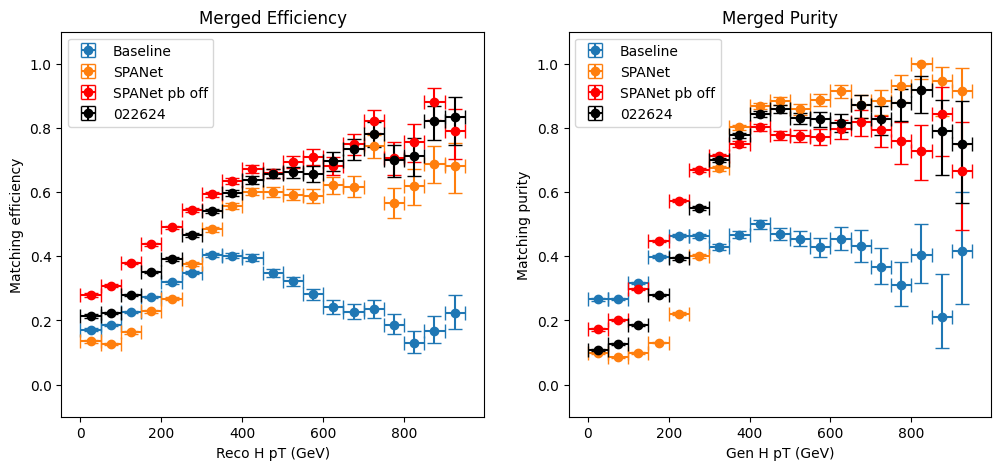

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].errorbar(x=bin_centers, y=eff_b, xerr=xerr, yerr=efferr_b, fmt='o', capsize=5, label='Baseline')
ax[0].errorbar(x=bin_centers, y=eff_s, xerr=xerr, yerr=efferr_s, fmt='o', capsize=5, label='SPANet')
ax[0].errorbar(x=bin_centers, y=eff_pb, xerr=xerr, yerr=efferr_pb, c='r', fmt='o', capsize=5, label='SPANet pb off')
ax[0].errorbar(x=bin_centers, y=eff_eval, xerr=xerr, yerr=efferr_eval, c='k', fmt='o', capsize=5, label=tag)

ax[1].errorbar(x=bin_centers, y=pur_b, xerr=xerr, yerr=purerr_b, fmt='o', capsize=5, label='Baseline')
ax[1].errorbar(x=bin_centers, y=pur_s, xerr=xerr, yerr=purerr_s, fmt='o', capsize=5, label='SPANet')
ax[1].errorbar(x=bin_centers, y=pur_pb, xerr=xerr, yerr=purerr_pb, c='r', fmt='o', capsize=5, label='SPANet pb off')
ax[1].errorbar(x=bin_centers, y=pur_eval, xerr=xerr, yerr=purerr_eval, c='k', fmt='o', capsize=5, label=tag)

ax[0].set(xlabel=r"Reco H pT (GeV)", ylabel=r"Matching efficiency", title=f"Merged Efficiency")
ax[1].set(xlabel=r"Gen H pT (GeV)", ylabel=r"Matching purity", title=f"Merged Purity")
ax[0].legend()
ax[1].legend()

ax[0].set_ylim([-0.1, 1.1])
ax[1].set_ylim([-0.1, 1.1])

In [32]:
eff_s, efferr_s = calc_eff(LUT_boosted_pred_spanet, None, bins)
pur_s, purerr_s = calc_pur(LUT_boosted_target_spanet, None, bins)

In [33]:
eff_b, efferr_b = calc_eff(LUT_boosted_pred_base, None, bins)
pur_b, purerr_b = calc_pur(LUT_boosted_target_base, None, bins)

In [34]:
eff_pb, efferr_pb = calc_eff(LUT_boosted_pred_pb, None, bins)
pur_pb, purerr_pb = calc_pur(LUT_boosted_target_pb, None, bins)

In [35]:
eff_eval, efferr_eval = calc_eff(LUT_boosted_pred_eval, None, bins)
pur_eval, purerr_eval = calc_pur(LUT_boosted_target_eval, None, bins)

(-0.1, 1.1)

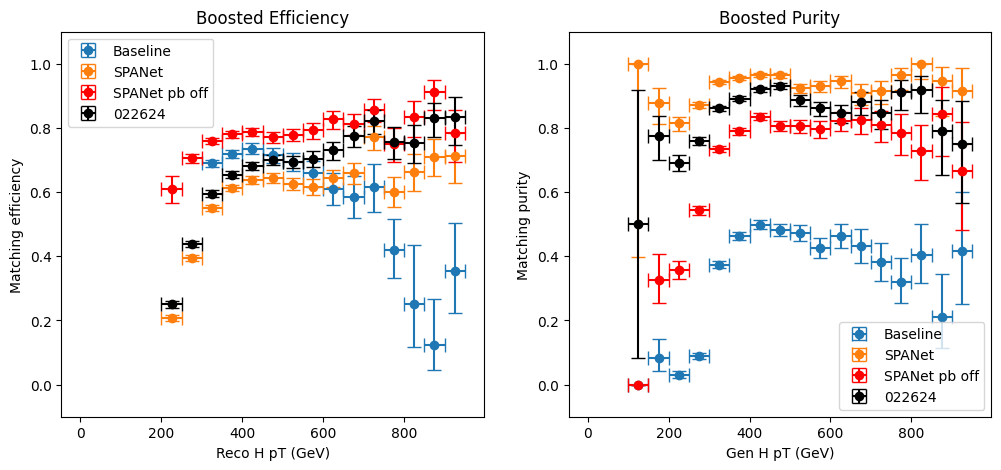

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].errorbar(x=bin_centers, y=eff_b, xerr=xerr, yerr=efferr_b, fmt='o', capsize=5, label='Baseline')
ax[0].errorbar(x=bin_centers, y=eff_s, xerr=xerr, yerr=efferr_s, fmt='o', capsize=5, label='SPANet')
ax[0].errorbar(x=bin_centers, y=eff_pb, xerr=xerr, yerr=efferr_pb, c='r', fmt='o', capsize=5, label='SPANet pb off')
ax[0].errorbar(x=bin_centers, y=eff_eval, xerr=xerr, yerr=efferr_eval, c='k', fmt='o', capsize=5, label=tag)

ax[1].errorbar(x=bin_centers, y=pur_b, xerr=xerr, yerr=purerr_b, fmt='o', capsize=5, label='Baseline')
ax[1].errorbar(x=bin_centers, y=pur_s, xerr=xerr, yerr=purerr_s, fmt='o', capsize=5, label='SPANet')
ax[1].errorbar(x=bin_centers, y=pur_pb, xerr=xerr, yerr=purerr_pb, c='r', fmt='o', capsize=5, label='SPANet pb off')
ax[1].errorbar(x=bin_centers, y=pur_eval, xerr=xerr, yerr=purerr_eval, c='k', fmt='o', capsize=5, label=tag)

ax[0].set(xlabel=r"Reco H pT (GeV)", ylabel=r"Matching efficiency", title=f"Boosted Efficiency")
ax[1].set(xlabel=r"Gen H pT (GeV)", ylabel=r"Matching purity", title=f"Boosted Purity")
ax[0].legend()
ax[1].legend()

ax[0].set_ylim([-0.1, 1.1])
ax[1].set_ylim([-0.1, 1.1])

In [37]:
eff_s, efferr_s = calc_eff(None, LUT_resolved_pred_spanet, bins)
pur_s, purerr_s = calc_pur(None, LUT_resolved_target_spanet, bins)

In [38]:
eff_b, efferr_b = calc_eff(None, LUT_resolved_pred_base, bins)
pur_b, purerr_b = calc_pur(None, LUT_resolved_target_base, bins)

In [39]:
eff_pb, efferr_pb = calc_eff(None, LUT_resolved_pred_pb, bins)
pur_pb, purerr_pb = calc_pur(None, LUT_resolved_target_pb, bins)

In [40]:
eff_eval, efferr_eval = calc_eff(None, LUT_resolved_pred_eval, bins)
pur_eval, purerr_eval = calc_pur(None, LUT_resolved_target_eval, bins)

(-0.1, 1.1)

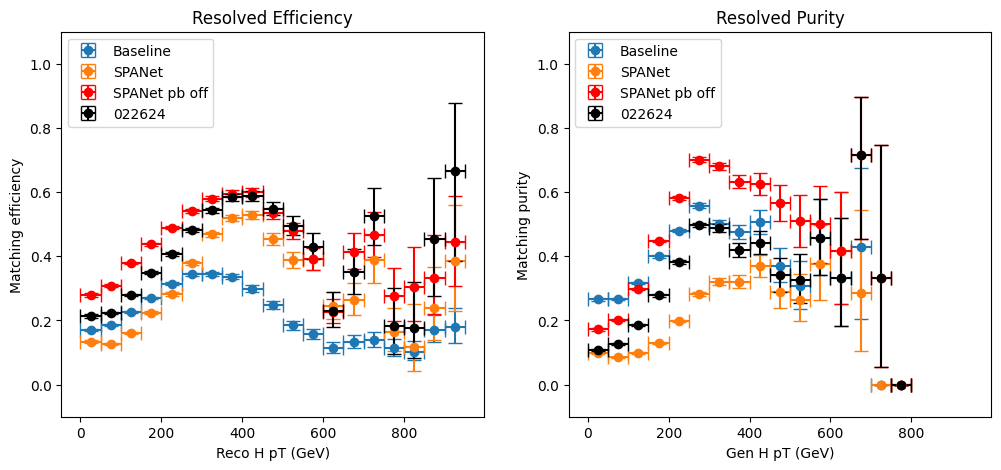

In [41]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].errorbar(x=bin_centers, y=eff_b, xerr=xerr, yerr=efferr_b, fmt='o', capsize=5, label='Baseline')
ax[0].errorbar(x=bin_centers, y=eff_s, xerr=xerr, yerr=efferr_s, fmt='o', capsize=5, label='SPANet')
ax[0].errorbar(x=bin_centers, y=eff_pb, xerr=xerr, yerr=efferr_pb, c='r', fmt='o', capsize=5, label='SPANet pb off')
ax[0].errorbar(x=bin_centers, y=eff_eval, xerr=xerr, yerr=efferr_eval, c='k', fmt='o', capsize=5, label=tag)

ax[1].errorbar(x=bin_centers, y=pur_b, xerr=xerr, yerr=purerr_b, fmt='o', capsize=5, label='Baseline')
ax[1].errorbar(x=bin_centers, y=pur_s, xerr=xerr, yerr=purerr_s, fmt='o', capsize=5, label='SPANet')
ax[1].errorbar(x=bin_centers, y=pur_pb, xerr=xerr, yerr=purerr_pb, c='r', fmt='o', capsize=5, label='SPANet pb off')
ax[1].errorbar(x=bin_centers, y=pur_eval, xerr=xerr, yerr=purerr_eval, c='k', fmt='o', capsize=5, label=tag)

ax[0].set(xlabel=r"Reco H pT (GeV)", ylabel=r"Matching efficiency", title=f"Resolved Efficiency")
ax[1].set(xlabel=r"Gen H pT (GeV)", ylabel=r"Matching purity", title=f"Resolved Purity")
ax[0].legend()
ax[1].legend()

ax[0].set_ylim([-0.1, 1.1])
ax[1].set_ylim([-0.1, 1.1])

## Code below shows the envelop effect

In [42]:
def calc_eff_envelop(LUT_boosted_pred, LUT_resolved_pred, bins):

    predHs = []

    # boosted H don't need post processing
    predHs_boosted = [predH for event in LUT_boosted_pred for predH in event]
    predHs += predHs_boosted

    # Remove overlapped resolved H_reco 
    # predHs_resolved = [predH[0:2] for event in LUT_resolved_pred for predH in event if predH[2]==0]
    predHs_resolved = [predH[0:2] for event in LUT_resolved_pred for predH in event]
    predHs += predHs_resolved

    # then merge into the list with their pT
    predHs = np.array(predHs)
    predHs_inds = np.digitize(predHs[:,1], bins)
    
    match_per_bin = []
    for bin_i in range(1, len(bins)):
        match_per_bin.append(predHs[:,0][predHs_inds==bin_i])
    match_per_bin = ak.Array(match_per_bin)
    
    merge_means = ak.mean(match_per_bin, axis=-1)
    
    merge_errs = np.abs(
        clopper_pearson_interval(num=ak.sum(match_per_bin, axis=-1),\
                             denom=ak.num(match_per_bin, axis=-1)) - merge_means
    )
    
    merge_effs = [merge_means, merge_errs]
    
    # calculate boosted part: 
    # numerator: number of correctly matched reco boosted higgs
    # denom: number of all reco higgs
    predHs_boosted = np.array(predHs_boosted)
    predHs_boosted_inds = np.digitize(predHs_boosted[:,1], bins)
    
    boosted_match_per_bin = []
    for bin_i in range(1, len(bins)):
        boosted_match_per_bin.append(predHs_boosted[:,0][predHs_boosted_inds==bin_i])
    boosted_match_per_bin = ak.Array(boosted_match_per_bin)
    
    boosted_part_means = ak.sum(boosted_match_per_bin, axis=-1)/ak.num(match_per_bin, axis=-1)
    
    boosted_errs = np.abs(
        clopper_pearson_interval(num=ak.sum(boosted_match_per_bin, axis=-1),\
                             denom=ak.num(match_per_bin, axis=-1)) - boosted_part_means
    )
    
    boosted_effs = [boosted_part_means, boosted_errs]
    
    # calcualte resolved part:
    # numerator: number of correctly matched reco resolved higgs (after overlap removal)
    # denom: number of all reco higgs
    predHs_resolved = np.array(predHs_resolved)
    predHs_resolved_inds = np.digitize(predHs_resolved[:,1], bins)
    
    resolved_match_per_bin = []
    for bin_i in range(1, len(bins)):
        resolved_match_per_bin.append(predHs_resolved[:,0][predHs_resolved_inds==bin_i])
    resolved_match_per_bin = ak.Array(resolved_match_per_bin)
    
    resolved_part_means = ak.sum(resolved_match_per_bin, axis=-1)/ak.num(match_per_bin, axis=-1)
    
    resolved_errs = np.abs(
        clopper_pearson_interval(num=ak.sum(resolved_match_per_bin, axis=-1),\
                             denom=ak.num(match_per_bin, axis=-1)) - resolved_part_means
    )
    
    resolved_effs = [resolved_part_means, resolved_errs]
    
    return merge_effs, boosted_effs, resolved_effs

In [43]:
def calc_pur_envelop(LUT_boosted_target, LUT_resolved_target, bins):

    targetHs = []

    # boosted H don't need post processing
    targetHs_boosted = [targetH for event in LUT_boosted_target for targetH in event]
    targetHs += targetHs_boosted

    # only consider resolved target H that doesn't have a corresponding boosted H target
    # targetHs_resolved = [targetH[0:2] for event in LUT_resolved_target for targetH in event if targetH[2]==0]
    targetHs_resolved = [targetH[0:2] for event in LUT_resolved_target for targetH in event]
    targetHs += targetHs_resolved

    # then merge into the list with their pT
    targetHs = np.array(targetHs)
    targetHs_inds = np.digitize(targetHs[:,1], bins)
    
    match_per_bin = []
    for bin_i in range(1, len(bins)):
        match_per_bin.append(targetHs[:,0][targetHs_inds==bin_i])
    match_per_bin = ak.Array(match_per_bin)
    
    merge_means = ak.mean(match_per_bin, axis=-1)
    
    merge_errs = np.abs(
        clopper_pearson_interval(num=ak.sum(match_per_bin, axis=-1),\
                             denom=ak.num(match_per_bin, axis=-1)) - merge_means
    )
    
    merge_purs = [merge_means, merge_errs]
    
    # calculate boosted part: 
    # numerator: number of correctly matched target boosted higgs
    # denom: number of all target higgs
    targetHs_boosted = np.array(targetHs_boosted)
    targetHs_boosted_inds = np.digitize(targetHs_boosted[:,1], bins)
    
    boosted_match_per_bin = []
    for bin_i in range(1, len(bins)):
        boosted_match_per_bin.append(targetHs_boosted[:,0][targetHs_boosted_inds==bin_i])
    boosted_match_per_bin = ak.Array(boosted_match_per_bin)
    
    boosted_part_means = ak.sum(boosted_match_per_bin, axis=-1)/ak.num(match_per_bin, axis=-1)
    
    boosted_errs = np.abs(
        clopper_pearson_interval(num=ak.sum(boosted_match_per_bin, axis=-1),\
                             denom=ak.num(match_per_bin, axis=-1)) - boosted_part_means
    )
    
    boosted_purs = [boosted_part_means, boosted_errs]
    
    # calcualte resolved part:
    # numerator: number of correctly matched target resolved higgs
    # denom: number of all target higgs
    targetHs_resolved = np.array(targetHs_resolved)
    targetHs_resolved_inds = np.digitize(targetHs_resolved[:,1], bins)
    
    resolved_match_per_bin = []
    for bin_i in range(1, len(bins)):
        resolved_match_per_bin.append(targetHs_resolved[:,0][targetHs_resolved_inds==bin_i])
    resolved_match_per_bin = ak.Array(resolved_match_per_bin)
    
    resolved_part_means = ak.sum(resolved_match_per_bin, axis=-1)/ak.num(match_per_bin, axis=-1)
    
    resolved_errs = np.abs(
        clopper_pearson_interval(num=ak.sum(resolved_match_per_bin, axis=-1),\
                             denom=ak.num(match_per_bin, axis=-1)) - resolved_part_means
    )
    
    resolved_purs = [resolved_part_means, resolved_errs]
    
    return merge_purs, boosted_purs, resolved_purs

In [44]:
merge_eff_s, boosted_eff_s, resolved_eff_s = calc_eff_envelop(LUT_boosted_pred_spanet, LUT_resolved_wOR_pred_spanet, bins)
merge_pur_s, boosted_pur_s, resolved_pur_s = calc_pur_envelop(LUT_boosted_target_spanet, LUT_resolved_wOR_target_spanet, bins)

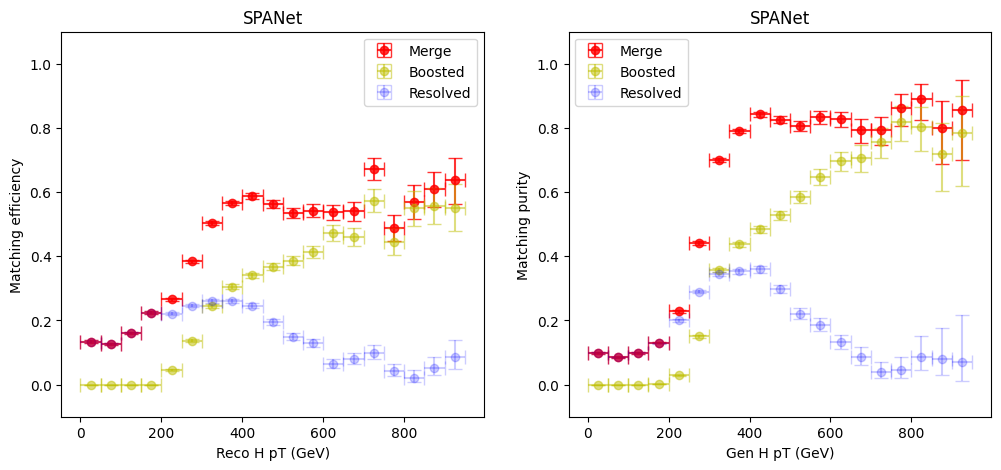

In [45]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].errorbar(x=bin_centers, y=merge_eff_s[0], c='r', xerr=xerr, yerr=merge_eff_s[1], fmt='o', capsize=5, label='Merge', alpha=0.8)
ax[0].errorbar(x=bin_centers, y=boosted_eff_s[0], c='y', xerr=xerr, yerr=boosted_eff_s[1], fmt='o', capsize=5, label='Boosted', alpha=0.5)
ax[0].errorbar(x=bin_centers, y=resolved_eff_s[0], c='b', xerr=xerr, yerr=resolved_eff_s[1], fmt='o', capsize=5, label='Resolved', alpha=0.2)

ax[1].errorbar(x=bin_centers, y=merge_pur_s[0], c='r', xerr=xerr, yerr=merge_pur_s[1], fmt='o', capsize=5, label='Merge', alpha=0.8)
ax[1].errorbar(x=bin_centers, y=boosted_pur_s[0], c='y', xerr=xerr, yerr=boosted_pur_s[1], fmt='o', capsize=5, label='Boosted', alpha=0.5)
ax[1].errorbar(x=bin_centers, y=resolved_pur_s[0], c='b', xerr=xerr, yerr=resolved_pur_s[1], fmt='o', capsize=5, label='Resolved', alpha=0.2)


ax[0].set(xlabel=r"Reco H pT (GeV)", ylabel=r"Matching efficiency", title=f"SPANet")
ax[1].set(xlabel=r"Gen H pT (GeV)", ylabel=r"Matching purity", title=f"SPANet")
ax[0].legend()
ax[1].legend()

ax[0].set_ylim([-0.1, 1.1])
ax[1].set_ylim([-0.1, 1.1])
plt.show()

In [46]:
merge_eff_b, boosted_eff_b, resolved_eff_b = calc_eff_envelop(LUT_boosted_pred_base, LUT_resolved_wOR_pred_base, bins)
merge_pur_b, boosted_pur_b, resolved_pur_b = calc_pur_envelop(LUT_boosted_target_base, LUT_resolved_wOR_target_base, bins)

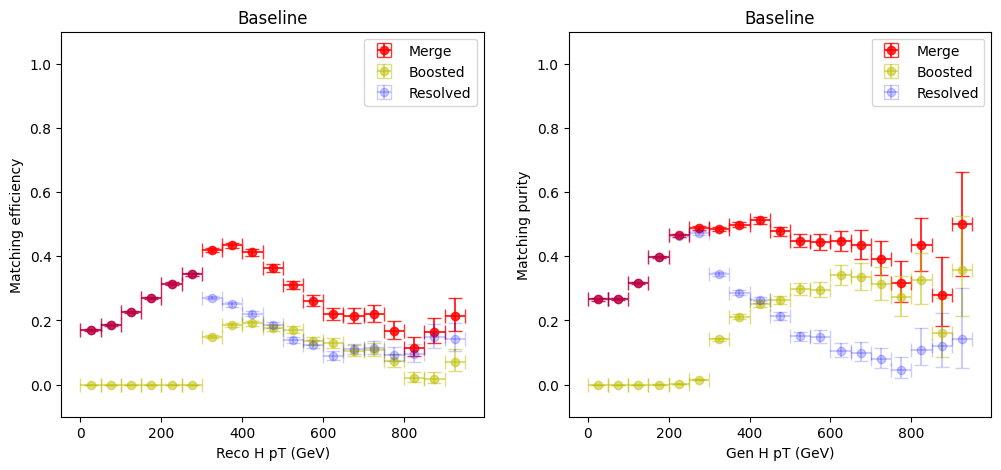

In [47]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].errorbar(x=bin_centers, y=merge_eff_b[0], c='r', xerr=xerr, yerr=merge_eff_b[1], fmt='o', capsize=5, label='Merge', alpha=0.8)
ax[0].errorbar(x=bin_centers, y=boosted_eff_b[0], c='y', xerr=xerr, yerr=boosted_eff_b[1], fmt='o', capsize=5, label='Boosted', alpha=0.5)
ax[0].errorbar(x=bin_centers, y=resolved_eff_b[0], c='b', xerr=xerr, yerr=resolved_eff_b[1], fmt='o', capsize=5, label='Resolved', alpha=0.2)

ax[1].errorbar(x=bin_centers, y=merge_pur_b[0], c='r', xerr=xerr, yerr=merge_pur_b[1], fmt='o', capsize=5, label='Merge', alpha=0.8)
ax[1].errorbar(x=bin_centers, y=boosted_pur_b[0], c='y', xerr=xerr, yerr=boosted_pur_b[1], fmt='o', capsize=5, label='Boosted', alpha=0.5)
ax[1].errorbar(x=bin_centers, y=resolved_pur_b[0], c='b', xerr=xerr, yerr=resolved_pur_b[1], fmt='o', capsize=5, label='Resolved', alpha=0.2)


ax[0].set(xlabel=r"Reco H pT (GeV)", ylabel=r"Matching efficiency", title=f"Baseline")
ax[1].set(xlabel=r"Gen H pT (GeV)", ylabel=r"Matching purity", title=f"Baseline")
ax[0].legend()
ax[1].legend()

ax[0].set_ylim([-0.1, 1.1])
ax[1].set_ylim([-0.1, 1.1])
plt.show()

In [48]:
merge_eff_pb, boosted_eff_pb, resolved_eff_pb = calc_eff_envelop(LUT_boosted_pred_pb, LUT_resolved_wOR_pred_pb, bins)
merge_pur_pb, boosted_pur_pb, resolved_pur_pb = calc_pur_envelop(LUT_boosted_target_pb, LUT_resolved_wOR_target_pb, bins)

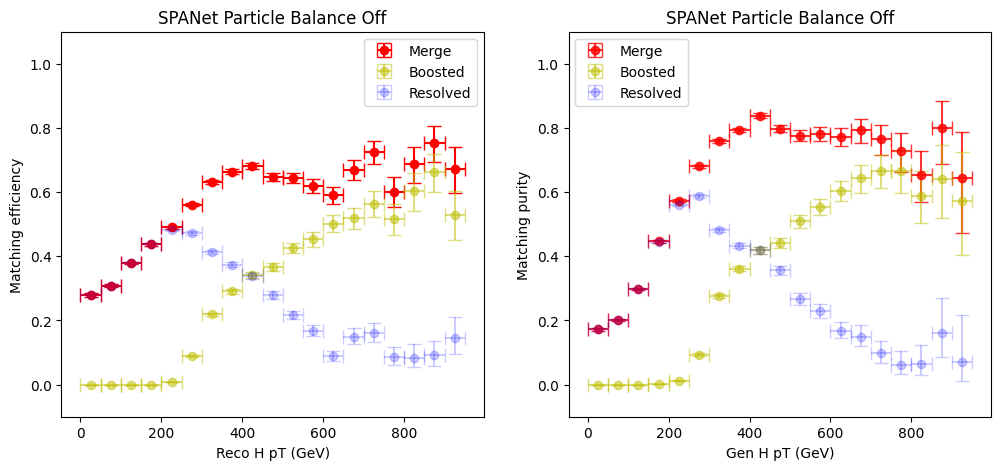

In [49]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].errorbar(x=bin_centers, y=merge_eff_pb[0], c='r', xerr=xerr, yerr=merge_eff_pb[1], fmt='o', capsize=5, label='Merge', alpha=1)
ax[0].errorbar(x=bin_centers, y=boosted_eff_pb[0], c='y', xerr=xerr, yerr=boosted_eff_pb[1], fmt='o', capsize=5, label='Boosted', alpha=0.5)
ax[0].errorbar(x=bin_centers, y=resolved_eff_pb[0], c='b', xerr=xerr, yerr=resolved_eff_pb[1], fmt='o', capsize=5, label='Resolved', alpha=0.2)

ax[1].errorbar(x=bin_centers, y=merge_pur_pb[0], c='r', xerr=xerr, yerr=merge_pur_pb[1], fmt='o', capsize=5, label='Merge', alpha=0.8)
ax[1].errorbar(x=bin_centers, y=boosted_pur_pb[0], c='y', xerr=xerr, yerr=boosted_pur_pb[1], fmt='o', capsize=5, label='Boosted', alpha=0.5)
ax[1].errorbar(x=bin_centers, y=resolved_pur_pb[0], c='b', xerr=xerr, yerr=resolved_pur_pb[1], fmt='o', capsize=5, label='Resolved', alpha=0.2)


ax[0].set(xlabel=r"Reco H pT (GeV)", ylabel=r"Matching efficiency", title=f"SPANet Particle Balance Off")
ax[1].set(xlabel=r"Gen H pT (GeV)", ylabel=r"Matching purity", title=f"SPANet Particle Balance Off")
ax[0].legend()
ax[1].legend()

ax[0].set_ylim([-0.1, 1.1])
ax[1].set_ylim([-0.1, 1.1])
plt.show()

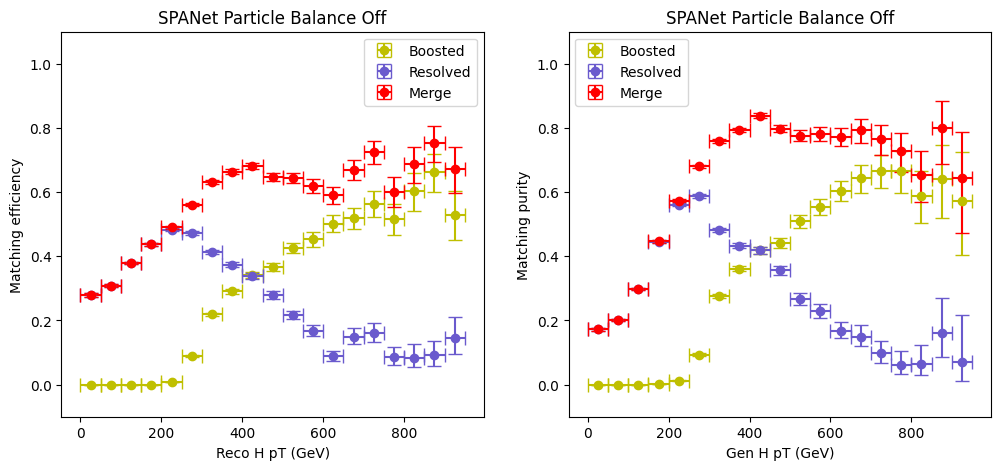

In [50]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].errorbar(x=bin_centers, y=boosted_eff_pb[0], c='y', xerr=xerr, yerr=boosted_eff_pb[1], fmt='o', capsize=5, label='Boosted')
ax[0].errorbar(x=bin_centers, y=resolved_eff_pb[0], c='slateblue', xerr=xerr, yerr=resolved_eff_pb[1], fmt='o', capsize=5, label='Resolved')
ax[0].errorbar(x=bin_centers, y=merge_eff_pb[0], c='r', xerr=xerr, yerr=merge_eff_pb[1], fmt='o', capsize=5, label='Merge')

ax[1].errorbar(x=bin_centers, y=boosted_pur_pb[0], c='y', xerr=xerr, yerr=boosted_pur_pb[1], fmt='o', capsize=5, label='Boosted')
ax[1].errorbar(x=bin_centers, y=resolved_pur_pb[0], c='slateblue', xerr=xerr, yerr=resolved_pur_pb[1], fmt='o', capsize=5, label='Resolved')
ax[1].errorbar(x=bin_centers, y=merge_pur_pb[0], c='r', xerr=xerr, yerr=merge_pur_pb[1], fmt='o', capsize=5, label='Merge')


ax[0].set(xlabel=r"Reco H pT (GeV)", ylabel=r"Matching efficiency", title=f"SPANet Particle Balance Off")
ax[1].set(xlabel=r"Gen H pT (GeV)", ylabel=r"Matching purity", title=f"SPANet Particle Balance Off")
ax[0].legend()
ax[1].legend()

ax[0].set_ylim([-0.1, 1.1])
ax[1].set_ylim([-0.1, 1.1])
plt.show()

In [51]:
LUT_boosted_target = LUT_boosted_target_pb
LUT_resolved_target = LUT_resolved_wOR_target_pb

In [52]:
targetHs = []

# boosted H don't need post processing
targetHs_boosted = [targetH for event in LUT_boosted_target for targetH in event]
targetHs += targetHs_boosted
num_tbH, _ = np.histogram(np.array(targetHs_boosted)[:,1], bins)
print("tbH:", num_tbH)

# only consider resolved target H that doesn't have a corresponding boosted H target
targetHs_resolved_raw =  [targetH[0:2] for event in LUT_resolved_target for targetH in event]
num_trH_raw, _ = np.histogram(np.array(targetHs_resolved_raw)[:,1], bins)
print("tbH wo/ OR:", num_trH_raw)

targetHs_resolved = [targetH[0:2] for event in LUT_resolved_target for targetH in event if targetH[2]==0]
num_trH, _ = np.histogram(np.array(targetHs_resolved)[:,1], bins)
print("tbH w/ OR:", num_trH)
targetHs += targetHs_resolved

# then merge into the list with their pT
targetHs = np.array(targetHs)
targetHs_inds = np.digitize(targetHs[:,1], bins)

match_per_bin = []
for bin_i in range(1, len(bins)):
    match_per_bin.append(targetHs[:,0][targetHs_inds==bin_i])
match_per_bin = ak.Array(match_per_bin)

merge_means = ak.mean(match_per_bin, axis=-1)

merge_errs = np.abs(
    clopper_pearson_interval(num=ak.sum(match_per_bin, axis=-1),\
                         denom=ak.num(match_per_bin, axis=-1)) - merge_means
)

merge_purs = [merge_means, merge_errs]

tbH: [   0    0    2   49  350 1180 2154 1731 1138  711  441  280  201  109
   84   56   37   19   12]
tbH wo/ OR: [ 7756 17578 18599 14734  9618  5668  3554  2051  1133   587   256   123
    72    31    18    10     9     6     2]
tbH w/ OR: [ 7756 17578 18598 14702  9356  4667  1640   556   219    97    49    24
    12     7     3     2     0     0     0]
